# Table of Contents

* [I- Setup](#setup)
    * [1.1) Imports](#imports)
    * [1.2) Utils](#utils)
    * [1.3) Board settings](#settings)
    * [1.4) Get content](#content)
    * [1.5) Get input image from folder](#folder)
    * [1.6) Preprocess input image](#preprocess)
    * [1.7) Function parameters](#params)
* [II- Gold data](#gold)
    * [2.1) OpenCV function](#opencv)
    * [2.2) Compute equivalent](#equivalent)
    * [2.3) Performances](#perfs_remake)
* [III- Accelerate function](#accelerate)
    * [3.1) Driver for custom IP](#driver)
    * [3.2) Load overlay](#overlay)
    * [3.3) Process image data](#process)
    * [3.4) Store image in output folder](#store)
    * [3.5) Performances](#perfs_overlay)
* [IV- HDMI source](#hdmi)
    * [4.1) Load base overlay](#base)
    * [4.2) Init HDMI](#init_hdmi)
    * [4.3) Init RGB LED](#init_rgb)
    * [4.4) Get image from HDMI](#get)
    * [4.5) Cleanup HDMI](#clean_hdmi)
    * [4.6) Cleanup RGB LED](#clean_rgb)
    * [4.7) Image processing](#img_proc)
    * [4.8) Export results](#export)

---

# I- Setup <a class="anchor" id="setup"></a>

## 1.1) Imports <a class="anchor" id="imports"></a>

In [1]:
import os
import time

import numpy as np
from PIL import Image, ImageOps

import cv2

from pynq import Overlay, Device, DefaultIP, DefaultHierarchy, allocate
from pynq.overlays.base import BaseOverlay
from pynq.ps import Clocks
from pynq.lib.dma import *
from pynq.lib.rgbled import *
from pynq.lib.video import *

## 1.2) Utils <a class="anchor" id="utils"></a>

In [2]:
def get_filenames(folder):
    """
    Read filenames from folder 'folder'.
    """
    try:
        files = [f for f in os.listdir(folder) if f.rpartition('.')[2] in ('png','jpg','jpeg')]
        print('Image filenames : ', files)
        return files
    except FileNotFoundError:
        raise FileNotFoundError("The path '{0}' doesn't exist.".format(folder)) 

In [3]:
def get_images(folder, files):
    """
    Get images from image filenames 'files' of folder 'folder'.
    """
    images = []
    for file in file_list: 
        image = Image.open(folder + '/' + file)
        # Appen image to list
        images.append(image)
    return images

In [4]:
def get_register_offset(overlay, ip, parameter):
    """
    Get 'parameter' memory offset of ip block 'ip' from overlay 'overlay'.
    """
    return overlay.ip_dict[ip]['registers'][parameter]['address_offset']

In [5]:
def get_params_offset(overlay, ip_name, param_list):
    """
    Get memory offset of parameters in list 'param_list' from ip 'ip_name' of overlay 'overlay'.
    """
    offsets = []
    for param in params:
        # Get memory offset
        addr = get_register_offset(overlay, ip_name, param)
        # Display value
        print('Address of {0} : {1}'.format(param, hex(addr)))
        # Append to list
        offsets.append(addr)
    return offsets

In [6]:
def preprocess_image(image):
    """
    Convert image 'image' to grayscale and then to a flatten array and get the image shape and the length of the flatten array.
    """
    # Convert image to grayscale
    gray_image = ImageOps.grayscale(image)
    # Convert PIL image to numpy array
    image_data = np.asarray(gray_image)
    # Get image shape
    image_shape = image_data.shape
    # Flatten image data
    flatten_data = image_data.flatten()
    # Get length of array
    array_length = len(flatten_data)
    return flatten_data, image_shape, array_length

In [7]:
def postprocess_data(data, shape):
    """
    Reshape (with shape 'shape') and convert array 'data' to image.
    """
    # Reshape output data
    array = data.reshape(shape)

    # Convert output data to image 
    image = Image.fromarray(np.uint8(array))
    return image

In [8]:
def get_duration(start, finish):
    """
    Compute and display the duration of a process that starts at 'start' and ends at 'end'.
    """
    delta_t = round((end - start) * 1000, 1)
    print('Duration : {0} ms'.format(delta_t))
    return delta_t

## 1.3) Board settings  <a class="anchor" id="settings"></a>

In [9]:
# Display device name
device = Device.active_device.name
print("Active device: {}".format(device))

Active device: Pynq-Z2


In [10]:
# Display CPU clock rate
print('PYNQ CPU clock rate : {} MHz'.format(Clocks.cpu_mhz))

# Display Programmable Logic (PL) clock rate
print('PYNQ Programmable Logic (PL) clock_0 rate : {} MHz'.format(Clocks.fclk0_mhz))

PYNQ CPU clock rate : 650.0 MHz
PYNQ Programmable Logic (PL) clock_0 rate : 100.0 MHz


## 1.4) Get content <a class="anchor" id="content"></a>

In [11]:
# Get current working directory
cwd = os.getcwd()
print("Current working directory: {}".format(cwd))

Current working directory: /home/xilinx/jupyter_notebooks/Luc


In [12]:
# Set image folder name$
folder_img = 'images/input_data'

# Read filenames from folder
file_list = get_filenames(folder_img)

Image filenames :  ['rio.jpeg']


In [13]:
# Extract images from files
images = get_images(folder_img, file_list)

In [14]:
# Folder for output image
output_folder = 'images/output_data'

## 1.5) Get input image from folder <a class="anchor" id="folder"></a>

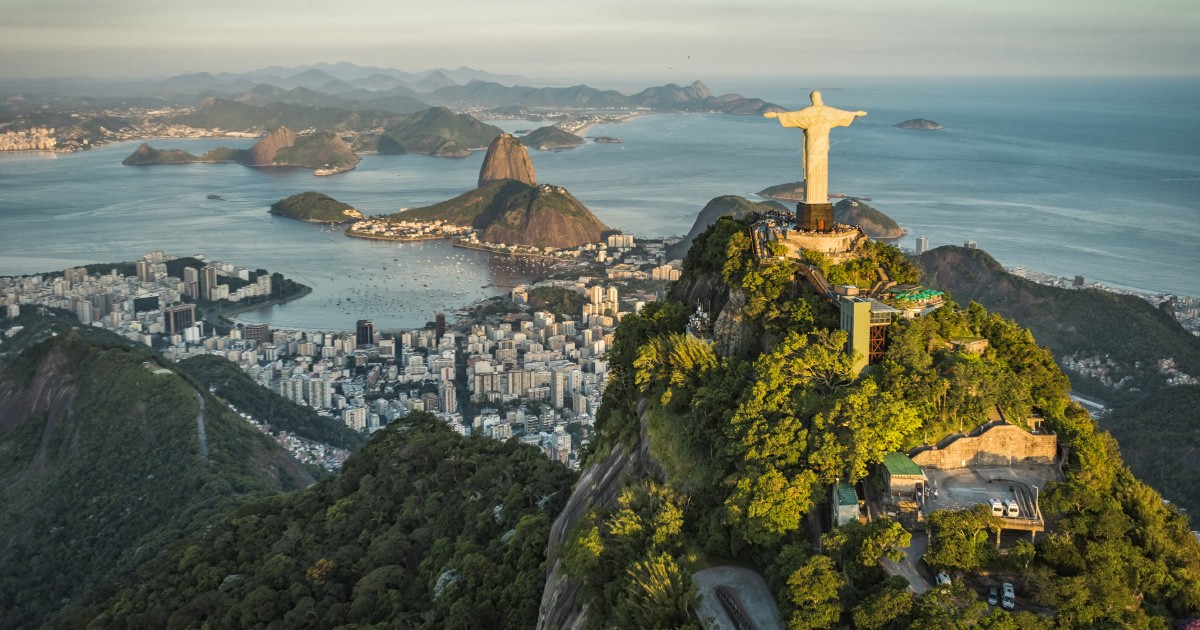

In [15]:
# Load an image
image = images[-1]

# Display image
display(image)

## 1.6) Preprocess input image <a class="anchor" id="preprocess"></a>

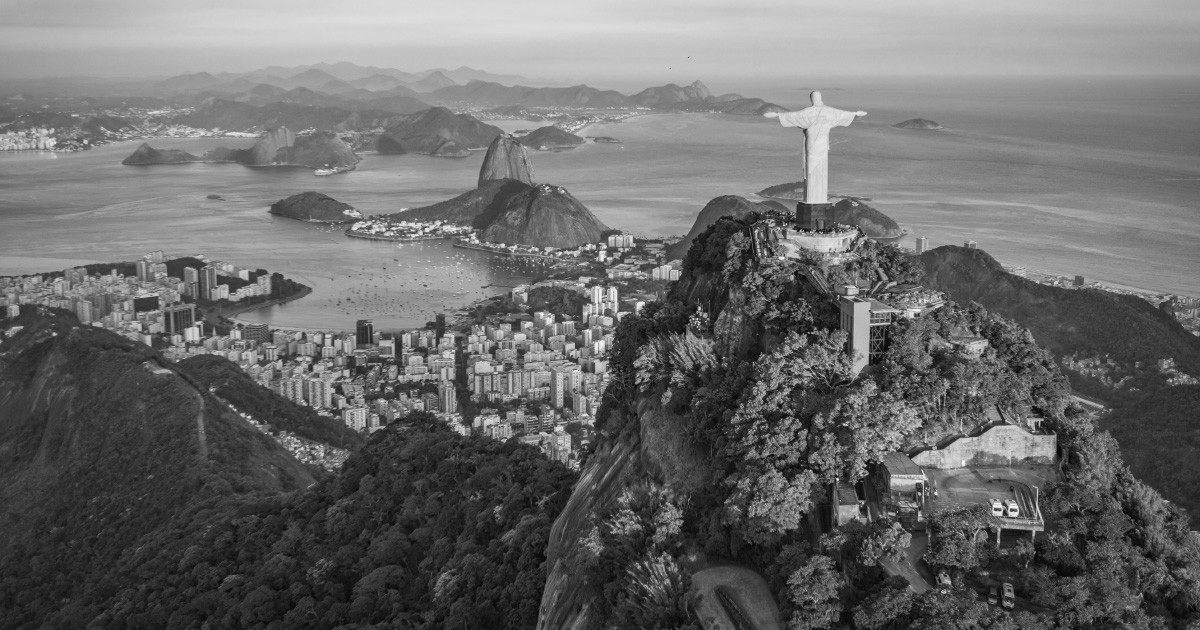

In [16]:
# Convert image to grayscale
gray_image = ImageOps.grayscale(image)

# Display image
display(gray_image)

In [17]:
# Convert PIL image to numpy array
image_data = np.asarray(gray_image)

if(image_data.ndim == 2):
    # Get image shape
    rows, cols = image_data.shape
    # Display image information
    print('Type:{0}, rows:{1}, cols:{2}'.format(image_data.dtype, rows, cols))

Type:uint8, rows:630, cols:1200


## 1.7) Function parameters <a class="anchor" id="params"></a>

In [18]:
# Set parameters for binary threshold
threshold = 160
max_val = 255

---

# II- Gold data <a class="anchor" id="gold"></a>

## 2.1) OpenCV function <a class="anchor" id="opencv"></a>

In [19]:
# Get start time
start = time.time()

# Compute binary threshold
thresh = cv2.threshold(image_data, threshold, max_val, cv2.THRESH_BINARY)[1]

# Get end time
end = time.time()

# Delta time
delta_t_gold = get_duration(start, end)

Duration : 6.6 ms


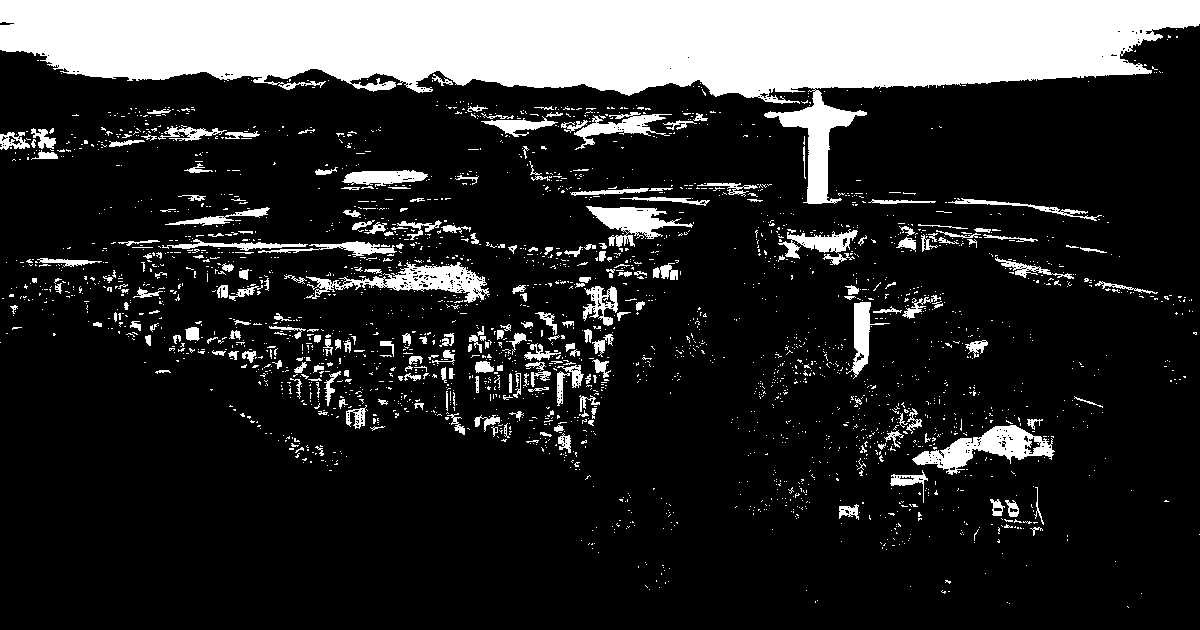

In [20]:
# Convert to image
gold_thresh_img = Image.fromarray(thresh)

# Display gold image
display(gold_thresh_img)

## 2.2) Compute equivalent <a class="anchor" id="equivalent"></a>

In [21]:
# Raw version
thresh_raw = np.copy(image_data)

# Get start time
start = time.time()

# Compute threshold
for i in range(rows):        
    for j in range(cols):    
        if(thresh_raw[i,j] > threshold):
          thresh_raw[i,j] = max_val  
        else:
          thresh_raw[i,j] = 0
        
# Get end time
end = time.time()

# Delta time
delta_t_remake = get_duration(start, end)

Duration : 34997.2 ms


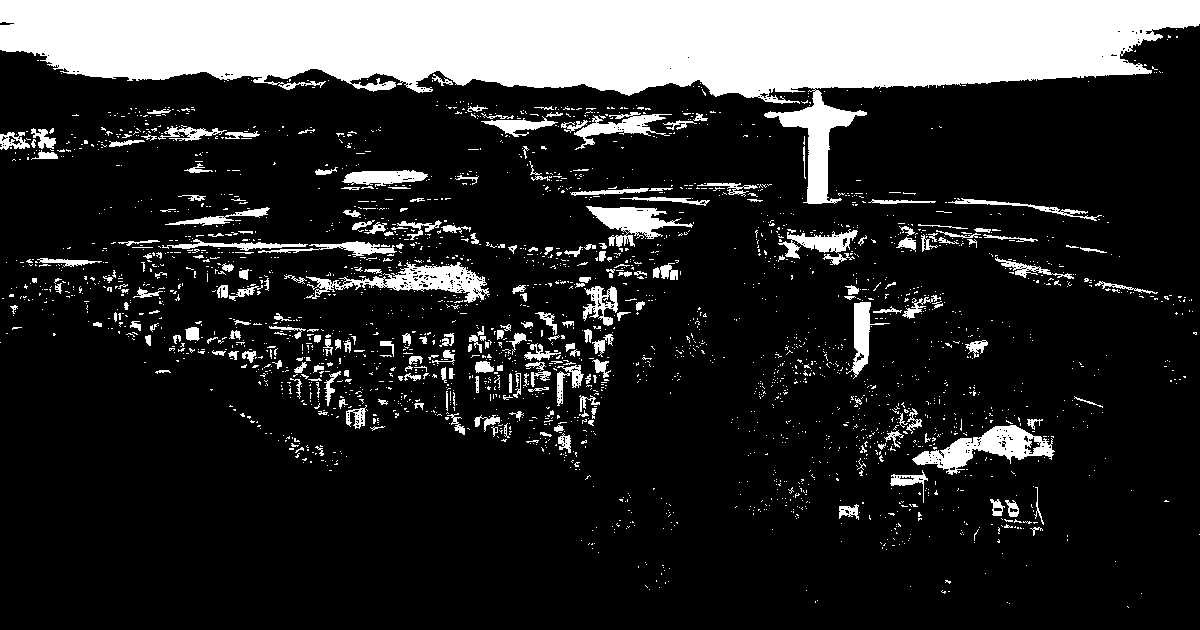

In [22]:
# Convert to image
raw_thresh_img = Image.fromarray(thresh_raw)

# Display gold image
display(raw_thresh_img)

## 2.3) Performances <a class="anchor" id="perfs_remake"></a>

In [23]:
# Calculate delta data
delta_remake = np.mean(np.abs(thresh-thresh_raw))
print('Delta values between OpenCV function and remake :', delta_remake)

Delta values between OpenCV function and remake : 0.0


In [24]:
# Acceleration factor bewteen remake and gold
accel_factor_remake = round(delta_t_remake / delta_t_gold)
print('Acceleration factor of OpenCV function over remake :', accel_factor_remake, 'times faster')

Acceleration factor of OpenCV function over remake : 5303 times faster


---

# III- Accelerate function <a class="anchor" id="accelerate"></a>

## 3.1) Driver for custom IP <a class="anchor" id="driver"></a>

In [25]:
# Name of custom IP block
ip_block_name = 'binary_threshold'

# Name of hierarchy above custom IP block
hierarchy_name = 'threshold'

In [26]:
class ThresholdDriver(DefaultIP):
    
    def __init__(self, description):
        """
        Driver for the 'arr_op' IP block.
        """
        super().__init__(description=description)

    # Bind to IP block
    bindto = ['xilinx.com:hls:' + ip_block_name + ':1.0']

    def max_val(self, value):
        """
        Set the 'max_val' parameter.
        """
        self.write(max_val_addr, value)
        
    def threshold(self, value):
        """
        Set the 'threshold' parameter.
        """
        self.write(threshold_addr, value)
        
    def length(self, value):
        """
        Set the 'length' parameter.
        """
        self.write(length_addr, value)
        
    def stream_threshold(self, stream, threshold, max_val, length):
        """
        Run the accelerated function with input data 'stream'.
        """
        # Set parameters
        self.max_val(max_val)
        self.threshold(threshold)
        self.length(length)
        # Run function
        with allocate(shape=(len(stream),), dtype=np.int32) as in_buffer, \
        allocate(shape=(len(stream),), dtype=np.int32) as out_buffer:
            # Feed input buffer
            for i, v, in enumerate(stream):
                in_buffer[i] = v
            # Transfert data to DMA
            dma.sendchannel.transfer(in_buffer)        
            dma.recvchannel.transfer(out_buffer)
            # Wait for completion
            dma.sendchannel.wait()                  
            dma.recvchannel.wait()
            # Get output data
            result = out_buffer.copy()
            # Delete buffers
            del in_buffer, out_buffer
        return result

## 3.2) Load overlay <a class="anchor" id="overlay"></a>

In [27]:
# Set overlay name
overlay_name = 'ol_thresh'

# Overlay folder
overlay_folder = 'overlay'

# Path to overlay bitstream
bitstream_path = cwd + '/' + overlay_folder + '/' + overlay_name + '.bit'

In [28]:
# Load overlay
overlay = Overlay(bitstream_path)

In [29]:
# Display the names of the overlay IP blocks
print('IP blocks :', list(overlay.ip_dict.keys()))

IP blocks : ['threshold/axi_dma', 'threshold/binary_threshold', 'processing_system7']


In [30]:
# Extract custom IP block
ip_binary_threshold = overlay.threshold.binary_threshold

# Extract DMA IP block associated
dma = overlay.threshold.axi_dma

In [31]:
# Get parameters's memory offset
params = ['max_val_V', 'threshold_V', 'length_V']
print('Parameters address offset :')
max_val_addr, threshold_addr, length_addr = get_params_offset(overlay, hierarchy_name + '/' + ip_block_name, params)

Parameters address offset :
Address of max_val_V : 0x20
Address of threshold_V : 0x18
Address of length_V : 0x10


## 3.3) Process image data <a class="anchor" id="process"></a>

In [32]:
# Preprocess image data
flatten_data, shape, length = preprocess_image(image)

In [33]:
# Get start time
start = time.time()

# Run IP block for binary trheshold
out_array = ip_binary_threshold.stream_threshold(flatten_data, threshold, max_val, length)

# Get end time
end = time.time()

# Delta time
delta_t_overlay = get_duration(start, end)

Duration : 2815.9 ms


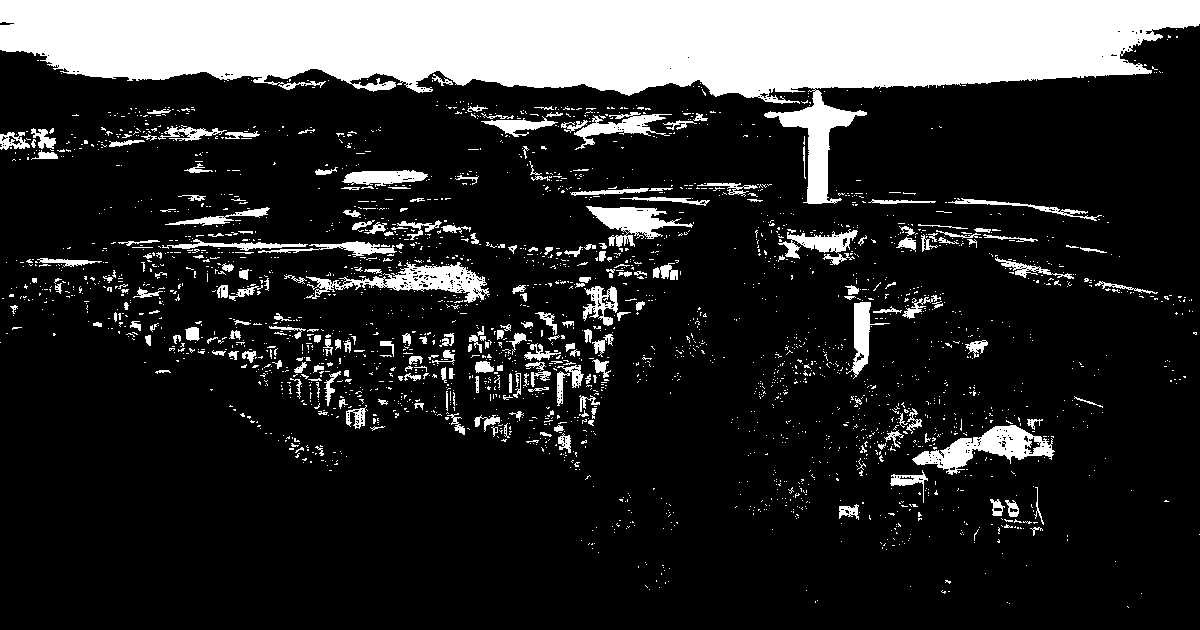

In [34]:
# Postprocess output data
image_out = postprocess_data(out_array, shape)

# Display image
display(image_out)

## 3.4) Store image in output folder <a class="anchor" id="store"></a>

In [35]:
# Save image to output folder
image_out.save(os.path.join(output_folder, 'result.jpg'))   

## 3.5) Performances <a class="anchor" id="perfs_overlay"></a>

In [36]:
# Compute delta data
delta_overlay = np.mean(np.abs(thresh - out_array.reshape(shape)))
print('Delta between gold and overlay : {0}'.format(delta_overlay))

Delta between gold and overlay : 0.0


In [37]:
# Acceleration factor bewteen overlay and gold
accel_factor_overlay= round(delta_t_overlay / delta_t_gold)
print('Acceleration factor of OpenCV function over overlay :', accel_factor_overlay, 'times faster')

Acceleration factor of OpenCV function over overlay : 427 times faster


In [38]:
# Acceleration factor bewteen overlay and gold
accel_factor_overlay_remake = round(delta_t_remake / delta_t_overlay)
print('Acceleration factor of overlay function over remake :', accel_factor_overlay_remake, 'times faster')

Acceleration factor of overlay function over remake : 12 times faster


---

# IV- HDMI source <a class="anchor" id="hdmi"></a>

## 4.1) Load base overlay <a class="anchor" id="base"></a>

In [39]:
# Load the base overlay for peripheral access
base_overlay = Overlay("base.bit")                         

In [40]:
# Display base overlay information
base_overlay?

In [41]:
# Print the name of the IP blocks
print('Base overlay IP blocks :', base_overlay.ip_dict.keys())

Base overlay IP blocks : dict_keys(['iop_pmoda/mb_bram_ctrl', 'switches_gpio', 'btns_gpio', 'video/hdmi_in/frontend/axi_gpio_hdmiin', 'video/hdmi_out/frontend/hdmi_out_hpd_video', 'rgbleds_gpio', 'leds_gpio', 'system_interrupts', 'iop_pmodb/mb_bram_ctrl', 'video/axi_vdma', 'audio_codec_ctrl_0', 'video/hdmi_out/frontend/axi_dynclk', 'video/hdmi_out/frontend/vtc_out', 'video/hdmi_in/frontend/vtc_in', 'video/hdmi_in/pixel_pack', 'video/hdmi_in/color_convert', 'video/hdmi_out/color_convert', 'video/hdmi_out/pixel_unpack', 'iop_arduino/mb_bram_ctrl', 'iop_rpi/mb_bram_ctrl', 'trace_analyzer_pmodb/axi_dma_0', 'trace_analyzer_pi/axi_dma_0', 'trace_analyzer_pi/trace_cntrl_64_0', 'trace_analyzer_pmodb/trace_cntrl_32_0', 'ps7_0'])


## 4.2) Init HDMI <a class="anchor" id="init_hdmi"></a>

In [42]:
# Initialize HDMI I/O
hdmi_in = base_overlay.video.hdmi_in
#hdmi_out = ol_base.video.hdmi_out

In [43]:
# Configure interface with color space and resolution
hdmi_in.configure()
#hdmi_out.configure(hdmi_in.mode)

# Run HDMI I/O
hdmi_in.start()
#hdmi_out.start()

In [44]:
# Display HDMI mode with resolution
print(str(hdmi_in.mode))

VideoMode: width=1280 height=720 bpp=24


## 4.3) Init RGB LED <a class="anchor" id="init_rgb"></a>

In [45]:
# Instantiate RGB LED (LD4)
RGB_LED_IDX = 4

# Access RGB LED from index
rgb_led = RGBLED(RGB_LED_IDX)

In [46]:
# Turn on the RGB LED and set its color
rgb_led.on(RGB_BLUE) 

## 4.4) Get image from HDMI <a class="anchor" id="get"></a>

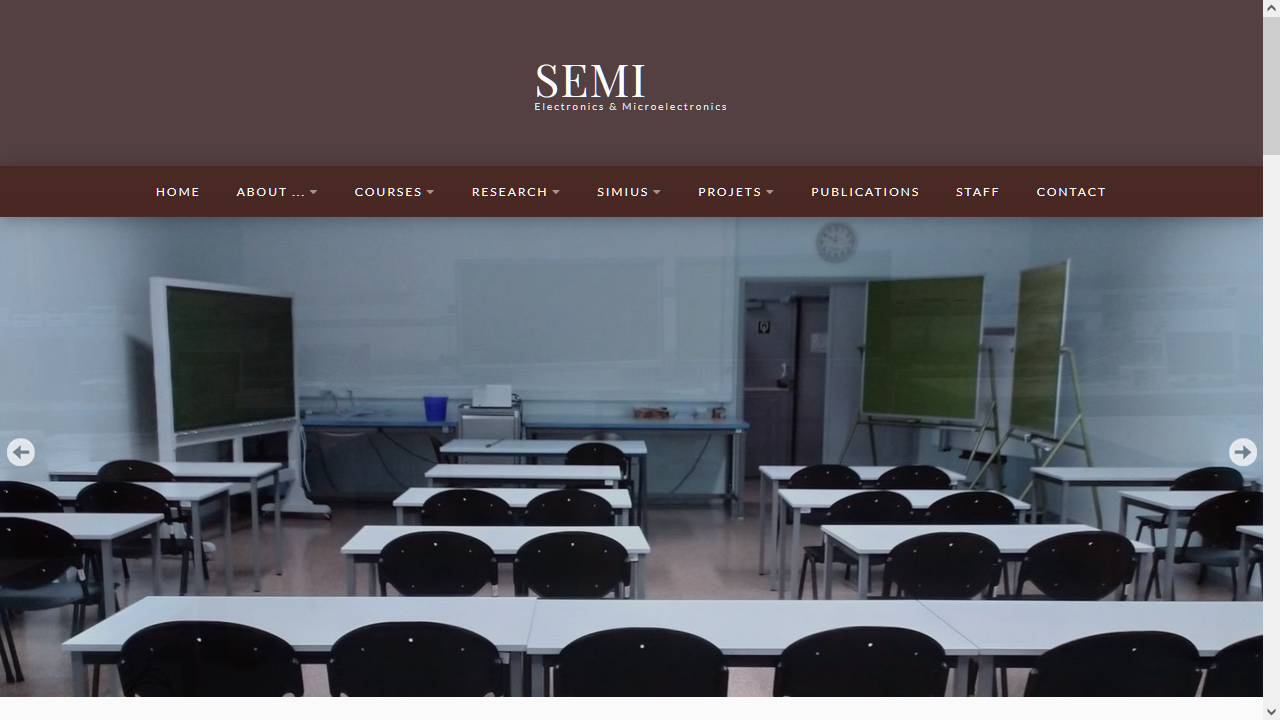

In [47]:
# Read HDMI input frame
frame_in = hdmi_in.readframe()

# Build image
stream_img = Image.fromarray(frame_in)

# Free frame
frame_in.freebuffer()

# Show image
display(stream_img)

## 4.5) Cleanup HDMI <a class="anchor" id="clean_hdmi"></a>

In [48]:
# Stop the DMA channel of the HDMI I/O module and empty the frame cache
#hdmi_out.stop()
hdmi_in.stop()

# Release HDMI I buffer
del hdmi_in

In [49]:
# Set the color of the RGB LED
rgb_led.write(RGB_WHITE)

## 4.6) Cleanup RGB LED <a class="anchor" id="clean_rgb"></a>

In [50]:
# Turn off the RGB LED
rgb_led.off()

 ## 4.7) Image processing <a class="anchor" id="img_proc"></a>

In [51]:
# Download the custom overlay bitstream again
#overlay.download()
overlay = Overlay(bitstream_path)

In [52]:
# Extract custom IP block
ip_binary_threshold = overlay.threshold.binary_threshold

# Extract DMA IP block associated
dma = overlay.threshold.axi_dma

In [53]:
# Preprocess image data
stream_data, shape, length = preprocess_image(stream_img)

In [55]:
# Get start time
start = time.time()

# Run IP block for binary trheshold
out_array = ip_binary_threshold.stream_threshold(stream_data, threshold, max_val, length)

# Get end time
end = time.time()

# Delta time
delta_t_overlay = get_duration(start, end)

Duration : 3503.6 ms


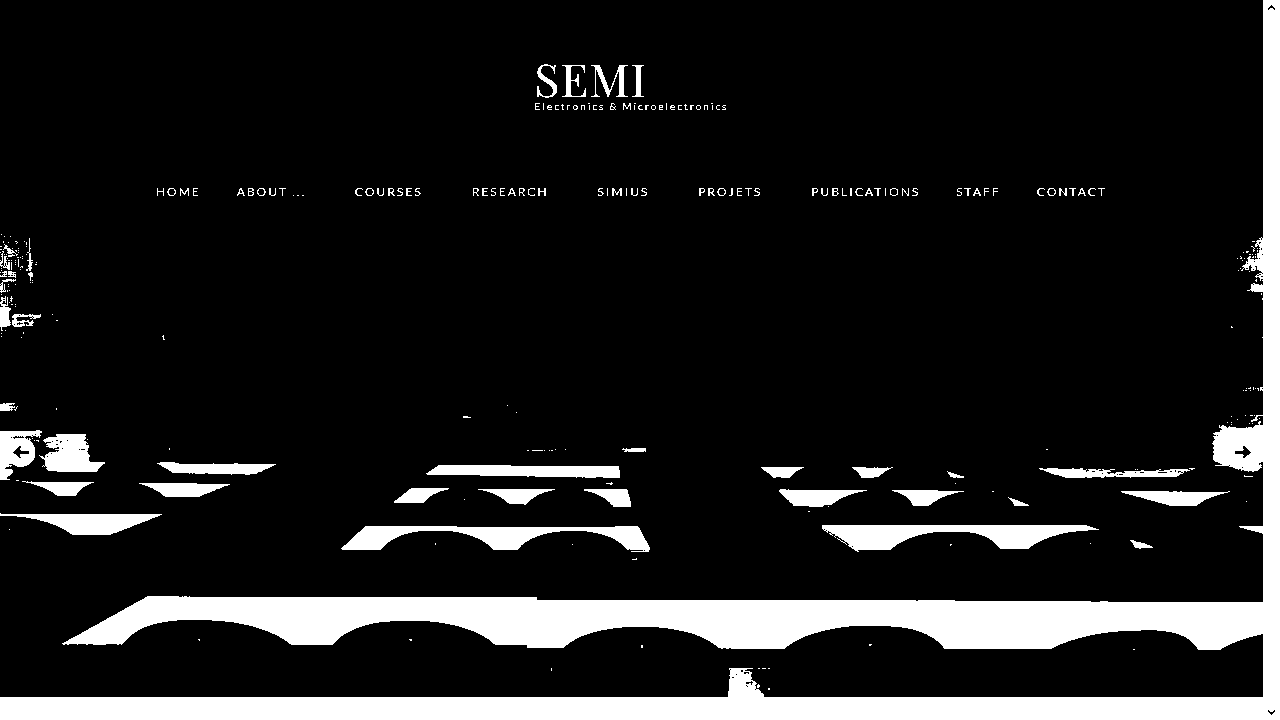

In [56]:
# Postprocess output data
image_out = postprocess_data(out_array, shape)

# Display image
display(image_out)

## 4.8) Export results <a class="anchor" id="export"></a>

In [2]:
# TODO : reload the base overlay and configure the HDMI-out

# Create frame for HDMI output
#frame_out= hdmi_out.newframe()

# Write frame
#hdmi_out.writeframe(frame_out)

# Release HDMI O buffer
#del hdmi_out